# Multiple Linear Regression from Scratch

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1) Load the concrete compressive strength dataset into a DataFrame
# (no equation; raw data load)
df = pd.read_csv('concrete_data.csv')

df.head()

# 2) Drop identifier or redundant columns if they exist (assignment guideline)
identifier_cols = [
    col for col in df.columns
    if col.lower() in {'id', 'serial no', 'serial_no', 'serialno', 'unnamed: 0', 'unnamed:0'}
]
if identifier_cols:
    df = df.drop(columns=identifier_cols)

# 3) Handle missing values (dataset has none, but this keeps pipeline robust)
if df.isnull().any().any():
    df = df.dropna()

# 4) Separate features X (all but last column) and target y (last column)
# (Notation follows PDF: X, y)
X = df.iloc[:, :-1].values  # shape: (m, n)
y = df.iloc[:, -1].values   # shape: (m,)

# 5) Split into training/testing sets so model evaluation is on unseen data
#    (X_train, y_train) used for gradient descent; (X_test, y_test) kept for evaluation
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42
)

# 6) Standardize features: implements Eq. 1 (Z = (X - μ)/σ)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # computes μ, σ on training set and applies: Eq. 1
X_test = scaler.transform(X_test)        # applies same μ, σ to test set (avoid leakage)

# 7) Reshape targets to column vectors so matrix math matches the hypothesis Xθ + b
# (Code uses column-vector y to match matrix equations in the PDF)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)

Training data shape: (824, 8)
Test data shape: (206, 8)
Training target shape: (824, 1)
Test target shape: (206, 1)


### Step 2: Model Training

In [2]:

import numpy as np

# Ensure inputs are numeric and have expected shapes/dtypes
X_train = np.asarray(X_train, dtype=np.float64)
X_test  = np.asarray(X_test, dtype=np.float64)
y_train = np.asarray(y_train, dtype=np.float64).reshape(-1, 1)
y_test  = np.asarray(y_test, dtype=np.float64).reshape(-1, 1)

# Basic shape checks
m, n = X_train.shape
assert y_train.shape[0] == m, f"Mismatched rows: X_train {X_train.shape}, y_train {y_train.shape}"

# Initialize parameters (θ small random, b = 0) per PDF
np.random.seed(42)
theta = np.random.normal(loc=0.0, scale=0.01, size=(n, 1))  # shape (n,1)
b = 0.0

# Hyper-parameters
learning_rate = 0.01
iterations = 1000
losses = []

# Training loop (batch gradient descent)
for i in range(iterations):
    # Eq. 2: Forward pass ŷ = X θ + b
    y_pred = X_train.dot(theta) + b  # implements Eq. 2

    # Error / residual vector (used in Eq. 3 and Eq. 4)
    error = y_pred - y_train  # shape (m,1)

    # Eq. 3: MSE loss L = (1/m) Σ (ŷ - y)^2
    loss = np.mean(error ** 2)  # implements Eq. 3
    losses.append(loss)

    # Eq. 4a: gradient w.r.t θ (2/m) X^T (ŷ - y)
    grad_theta = (2 / m) * X_train.T.dot(error)  # implements Eq. 4a
    # Eq. 4b: gradient w.r.t b (2/m) Σ (ŷ - y)
    grad_b = (2 / m) * np.sum(error)            # implements Eq. 4b

    # Eq. 5: parameter update θ ← θ − α ∇_θ L ; b ← b − α ∇_b L
    theta -= learning_rate * grad_theta  # implements Eq. 5
    b -= learning_rate * grad_b         # implements Eq. 5

    # Monitor (console output)
    if (i + 1) % 100 == 0:
        print(f'Iteration {i+1}/{iterations}, Loss: {loss:.4f}')

# Keep final theta and b for evaluation
print('Training complete.')

Iteration 100/1000, Loss: 145.2264
Iteration 200/1000, Loss: 116.9927
Iteration 300/1000, Loss: 114.9704
Iteration 400/1000, Loss: 114.0423
Iteration 500/1000, Loss: 113.4471
Iteration 600/1000, Loss: 113.0251
Iteration 700/1000, Loss: 112.7018
Iteration 800/1000, Loss: 112.4399
Iteration 900/1000, Loss: 112.2199
Iteration 1000/1000, Loss: 112.0309
Training complete.


In [3]:
# Forward pass on the normalized test features (ŷ_test = X_test θ + b) — implements test hypothesis (Eq. 6)
y_pred_test = np.dot(X_test, theta) + b

# Compute test MSE using the same formula as during training (Eq. 6)
mse = np.mean((y_pred_test - y_test) ** 2)
print(f'Mean Squared Error on Test Set: {mse:.4f}')

Mean Squared Error on Test Set: 96.7179


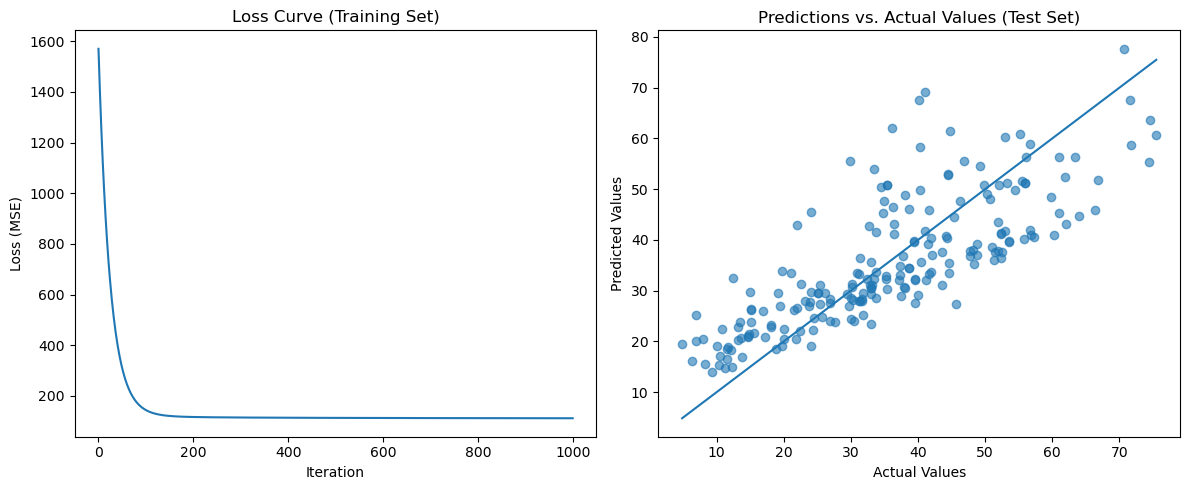

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# ----------------------------------------------------------------------------
# Plot 1: Training loss vs. iteration to monitor gradient descent convergence
# ----------------------------------------------------------------------------
plt.subplot(1, 2, 1)
plt.plot(losses, color='tab:blue')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.title('Loss Curve (Training Set)')

# ----------------------------------------------------------------------------
# Plot 2: Scatter plot of actual vs. predicted compressive strength on test set
# If predictions are perfect, points lie on the 45° line y = x.
# ----------------------------------------------------------------------------
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs. Actual Values (Test Set)')

plt.tight_layout()
plt.show()

In [ ]:
# Bonus: Hyper-parameter Tuning 
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
best_mse = float('inf')
best_lr = None

for lr in learning_rates:
    print(f'Training with learning rate: {lr}')

    # Reinitialize parameters per PDF: θ ~ N(0, 0.01), b = 0
    np.random.seed(42)
    theta = np.random.normal(loc=0.0, scale=0.01, size=(X_train.shape[1], 1))  # θ init
    b = 0.0
    iterations = 1000

    for _ in range(iterations):
        # Eq. 2: hypothesis on train ŷ = X_train θ + b
        y_pred = np.dot(X_train, theta) + b

        # Residuals (used in Eq. 3, 4)
        error = y_pred - y_train

        # Eq. 4a: ∇θ L = (2/m) X_train^T (ŷ − y)
        grad_theta = (2 / len(X_train)) * np.dot(X_train.T, error)
        # Eq. 4b: ∇b L = (2/m) Σ(ŷ − y)
        grad_b = (2 / len(X_train)) * np.sum(error)

        # Eq. 5: θ ← θ − α ∇θ L ; b ← b − α ∇b L
        theta -= lr * grad_theta
        b -= lr * grad_b

    # Evaluate on test set
    # Eq. 2 (test): ŷ_test = X_test θ + b
    y_pred_test = np.dot(X_test, theta) + b
    # Eq. 6 (test MSE): (1/m_test) Σ (ŷ_test − y_test)^2
    mse = np.mean((y_pred_test - y_test) ** 2)
    print(f'MSE on Test Set: {mse:.4f}')

    if mse < best_mse:
        best_mse = mse
        best_lr = lr

print(f'Best learning rate: {best_lr} with MSE: {best_mse:.4f}')